In this part of the exercise, you will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Check out the data file
!head ../data/ex2data2.txt

0.051267,0.69956,1
-0.092742,0.68494,1
-0.21371,0.69225,1
-0.375,0.50219,1
-0.51325,0.46564,1
-0.52477,0.2098,1
-0.39804,0.034357,1
-0.30588,-0.19225,1
0.016705,-0.40424,1
0.13191,-0.51389,1


In [3]:
data = pd.read_csv('../data/ex2data2.txt', sep=',', header=None, names=['Test1', 'Test2', 'Pass'])
data.head()

,Test1,Test2,Pass
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [4]:
data.describe()

,Test1,Test2,Pass
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


Scale of Test values are similar. I will not apply Standardization. But if means and standart deviations were really far apart, it may have made sense to standardize the data for the optimization purposes. We can see it on a box plot. 

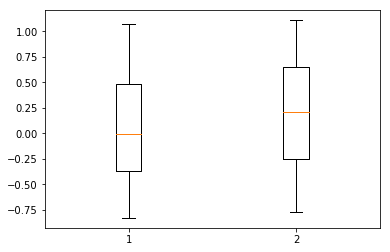

In [5]:
plt.figure()
plt.boxplot([data['Test1'], data['Test2']]);

Let's change the visual style:

In [6]:
plt.style.use('ggplot')

Finally, let's visualize the data at hand:

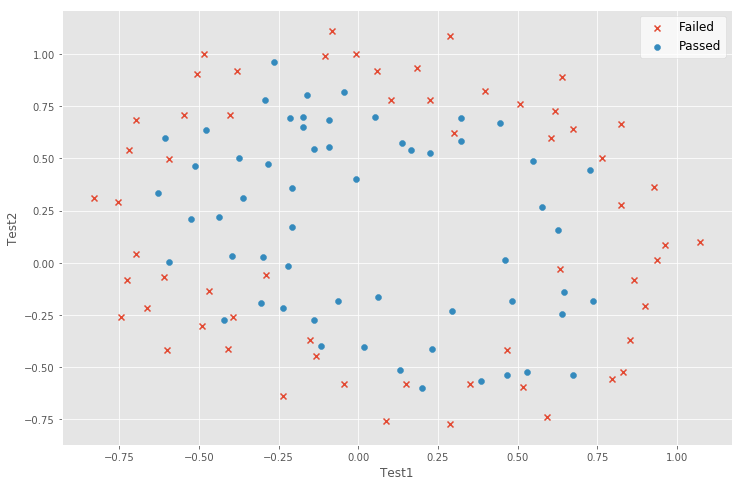

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(data[data["Pass"] == 0]["Test1"], data[data["Pass"] == 0]["Test2"], 
           marker='x', label='Failed')

ax.scatter(data[data["Pass"] == 1]["Test1"], data[data["Pass"] == 1]["Test2"], 
           label='Passed')

ax.legend(frameon = True, fontsize="large", facecolor = "White", framealpha = 0.7)
ax.set_xlabel('Test1')
ax.set_ylabel('Test2');

A linear seperator will not cut it here, and as a result we are going to implement 5th degree polynomial regression here. It is an overkill but we will use the regularization to get rid of unnecessary elements.

There is a MapFeature module in the homework written in Octave code. Using this code and the code from @jdwittenauer repo, I will transform the Dataset at hand to have the following transformation on our dataframe:

$mapFeature(x) = [x_1, x_2, x_1^2, x_1 x_2,x_2^2,..., x_1x_2^5,x_2^6]$

In [9]:
#let's first keep original data set as I will modify the dataframe
data_or = data.copy()

#There is the MapFeature.m 
#I think there was a mistake in his implementation, I corrected it
degree = 7

for i in range(1, degree):
    for j in range(0, i+1):
        data["T" + str(i-j) + str(j)] = np.power(data["Test1"], i-j) * np.power(data["Test2"], j)

In [10]:
data.drop(['Test1','Test2'], axis=1, inplace=True)
data.insert(1, "Ones", 1)
data.head()

,Pass,Ones,T10,T01,T20,T11,T02,T30,T21,T12,...,T23,T14,T05,T60,T51,T42,T33,T24,T15,T06
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


"As a result of this mapping, our vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector. "

We have 28 columns + 1 column for results as well. Finally define the numpy input and output arrays, initial theta value and check the dimensions for them

In [11]:
X = data.iloc[:,1:]
y = data.iloc[:,0]

X = np.asarray(X.values)
y = np.asarray(y.values)
theta = np.zeros(X.shape[1])
#check the dimensions
X.shape, y.shape, theta.shape

((118, 28), (118,), (28,))

**Regularization**

Regularization means we will add the following item to our old cost function:

$J(\theta) = J_{\text{old}}(\theta) + \frac{\lambda}{2m} \sum_{j=1}^{k}\theta_j^2$

In [12]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def h(theta, X):
    """
    Hypothesis Function where
    X is an n x k dimensional array of explanatory variables
    theta is a array with k elements of multipliers for linear function
    Result will be one dimensional vector of n variables
    """
    return sigmoid(np.dot(X, theta))

In [13]:
#Now the cost function
def cost_function(theta, Lambda, X, y):
    """
    This is a cost function that returns the cost of theta given X and y
    X is an n x k dimensional array of explanatory variables
    y is a one dimensional array with n elements of explained variables
    theta is a vector with k elements of multipliers for linear function
    """
    
    item1 = - y.flatten() * np.log(h(theta, X))
    item2 = -(1 - y.flatten()) * np.log(1 - h(theta, X))
    item3 = Lambda/(2*X.shape[0]) * np.sum(np.power(theta, 2)[1:])
    return np.sum(item1 + item2) / (X.shape[0]) + item3

$\frac{\partial J(\theta)}{\partial \theta_{j}} = \frac{1}{n} \sum\limits_{i=1}^n (h_{\theta}(x^{i}) - y^i)x_j^i$

In [23]:
def gradient(theta, Lambda, X, y):
    """
    This function will take in theta value and calculate the gradient 
    descent values.
    X is an n x k matrix of explanatory variables
    y is a nsized e of explained variables
    theta is a vector with k elements of multipliers for linear function
    """
    errors = h(theta, X) - y
    #errors will be calculated more than once, so let's do it once and store it
    correction2 = (Lambda/X.shape[0]) * theta
    correction2[0] = 0.0
    correction = np.sum(errors.reshape((X.shape[0], 1)) * X, axis=0) * (1.0 / X.shape[0])
    return correction + correction2

The cost for Lambda=1 and theta=0 is:

In [29]:
theta=np.zeros(X.shape[1])
cost_function(theta, 1, X, y)

0.6931471805599454

**Finding the Parameter**
Finally let's apply our optimization method and find the optimal theta values

In [42]:
import scipy.optimize as opt  

Lambda = 1.0
theta = np.zeros(X.shape[1])
result = opt.minimize(fun=cost_function, method='TNC', 
                      jac= gradient, x0=theta, args=(Lambda, X,y), options={'maxiter':400})


result

     fun: 0.52900272996449349
     jac: array([ -2.14982132e-06,   6.79422333e-07,  -3.48724652e-07,
         8.76157691e-07,  -4.07783535e-08,  -9.33390864e-07,
        -5.14534241e-07,   1.71241503e-08,   1.55194971e-08,
        -9.72519687e-07,   6.96625774e-08,   3.55365987e-08,
        -2.79468193e-07,   1.79679800e-07,   2.33391240e-07,
         1.47161499e-07,  -2.11752866e-07,   6.16737240e-07,
        -9.28573344e-08,  -5.27801203e-08,  -1.48150657e-06,
         2.31257827e-07,   1.80352893e-07,  -1.31851751e-07,
        -7.16896563e-08,  -4.12308012e-07,   1.65466749e-08,
        -7.34706738e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 32
     nit: 7
  status: 1
 success: True
       x: array([ 1.27271027,  0.62529965,  1.18111686, -2.01987399, -0.91743189,
       -1.43166929,  0.12393227, -0.36553118, -0.35725403, -0.17516292,
       -1.45817009, -0.05098418, -0.61558554, -0.27469165, -1.19271298,
       -0.24217841, -0.20603298, -0.04466178, -0.27778951, -0.29

Interesting tidbit: if you don't use the gradient function, it takes 750 loops. But if you use it it takes 32. Cost functions are very close.

Let's check the accuracy rate of our prediction function.

In [43]:
theta_opt = result['x']

def prediction_function(theta, X):
    return h(theta, X) >= 0.5

total_corrects = np.sum((y.flatten() == prediction_function(theta_opt, X)))
total_dpoints = X.shape[0]

accuracy_rate = total_corrects/total_dpoints
accuracy_rate

0.83050847457627119

**Plotting the decision boundary**

We will plot the decision boundary. In order to that I will create a 3d grid with values of test1 and test2 data, and the corresponding $h_{\theta}(X)$ (Acutally we will only find $\theta X$ since $h$ is one to one function). Using this data we can use the plot-contour level functions to find where $\theta X = 0$ since this is where the decision boundary is.

In order to this we need to write the MapFeature function explicitly. It should take in arrays or values and give us polynomial elements of them. 

In [85]:
def MapFeature(x1, x2):
    """
    This takes in two n elements vector arrays, then builds a
    n x 28 dimensional array of features 
    """
    #flatten the vectors in case:
    x1 = x1.flatten()
    x2 = x2.flatten()
    num_ele = len(x1) 
    degrees = 6
    
    res_ar = np.ones( (len(x1), 1) )
    
    for i in range(1, degrees+1):
        for j in range(0, i+1):
            res1 = np.power(x1, i-j) 
            res2 = np.power(x2, j)
            res3 = np.multiply(res1, res2).reshape( (num_ele, 1) )
            res_ar = np.hstack(( res_ar, res3 ))
    return res_ar


Let's check if our function work properly:

In [86]:
#The following code checks if there are any non-equal elements. 
np.count_nonzero(MapFeature(X[:,1],X[:,2]) != X)

0

Now let's define a function to draw counters. I have used the code from the homework and @kaleko's website. In order to repeat the image from the homework, I had to transpose zvals like Prof Ng did in his codes. To be honest, I don't know why we had to do this.

Our function will also show the accuracy rate before it shows the graph it drew. Quite handy.

In [153]:
def Draw_Contour(X, y, Lambda):
    #First we need to find optimal Theta
    theta_initial = np.zeros(X.shape[1])
    result = opt.minimize(fun=cost_function, method='TNC', jac= gradient, 
                          x0=theta_initial, args=(Lambda, X,y), options={'maxiter':400, 'disp':False})
    
    theta = result['x']
    #Next define the grids
    xvals = np.linspace(-1,1.5,50)
    yvals = np.linspace(-1,1.5,50)
    zvals = np.zeros((len(xvals),len(yvals)))

    for i, xv in enumerate(xvals):
        for j, yv in enumerate(yvals):
            features = MapFeature(np.array(xv), np.array(yv))
            zvals[i, j] = np.dot(features, theta)
    zvals = zvals.transpose()
    #To be honest I don't know why we transpose but this is the way it is in 
    #the code provided by Professor Ng. 
    
    #Now draw the graph. I reused some code from before. 
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.scatter(X[(y == 0), 1], X[(y == 0), 2], marker='x', label='Failed')
    
    ax.scatter(X[(y == 1), 1], X[(y == 1), 2], label='Passed')
    
    mycontour = ax.contour( xvals, yvals, zvals, [0], label="boundary")
    myfmt = { 0:'Lambda = %d'%Lambda}
    ax.clabel(mycontour, inline=1, fontsize=15, fmt=myfmt)
    
        
    ax.legend(frameon = True, fontsize="large", facecolor = "White", framealpha = 0.7)
    ax.set_xlabel('Test1')
    ax.set_ylabel('Test2')
    #Our function will also show the accuracy rate as it draws the graph
    
    total_corrects = np.sum((y.flatten() == prediction_function(theta, X)))
    total_dpoints = X.shape[0]

    accuracy_rate = total_corrects/total_dpoints
    return accuracy_rate


Let's try our function for different Lambda values, for Lambda = 0, 1, 10

0.88135593220338981

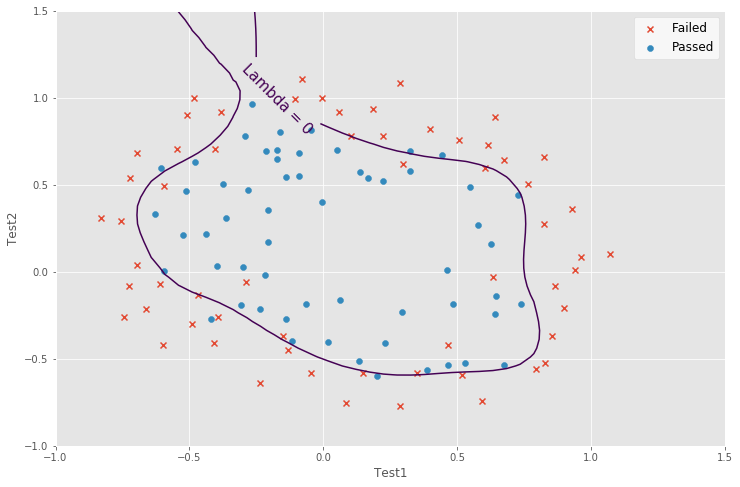

In [161]:
Draw_Contour(X, y, 0.00001)

0.83050847457627119

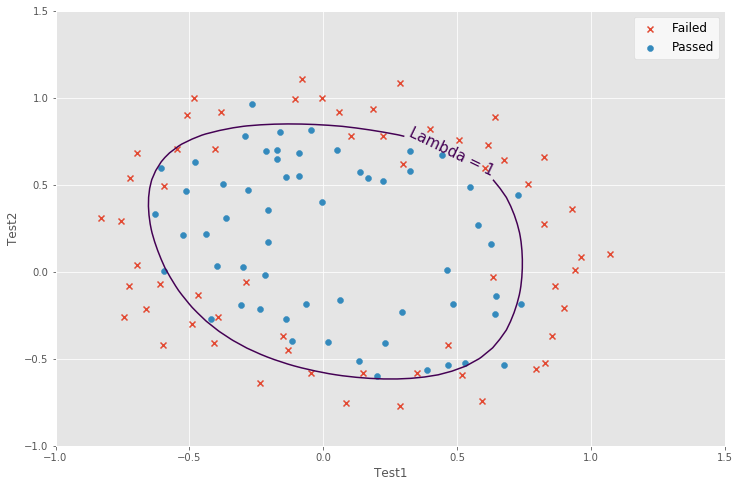

In [162]:
Draw_Contour(X, y, 1.0)

0.74576271186440679

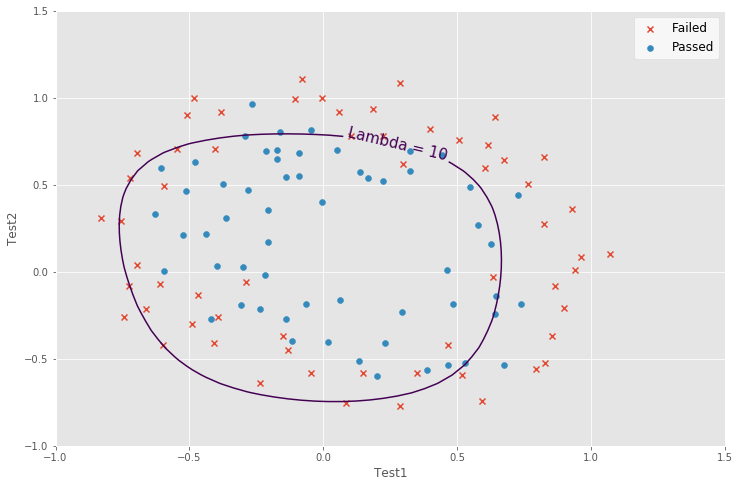

In [163]:
Draw_Contour(X, y, 10)